# SKIN CANCER DETECTION & CLASSIFICATION

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

## DATA

In [3]:
# Reading files using file name from the csv and add then corresponding image in a pandas dataframe along with labels. 

skin_df = pd.read_csv('DATA/HAM10000_metadata.csv')

In [4]:
skin_df.head()  # Default is 5 rows

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

## Image Data Loading and Visualization of Skin Lesion Samples

#### Now Adding Images to the above CSV file
The code loads image paths, associates them with metadata in a DataFrame, reads the images, visualizes random samples from each skin lesion category, and saves the plot as a high-resolution image.


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


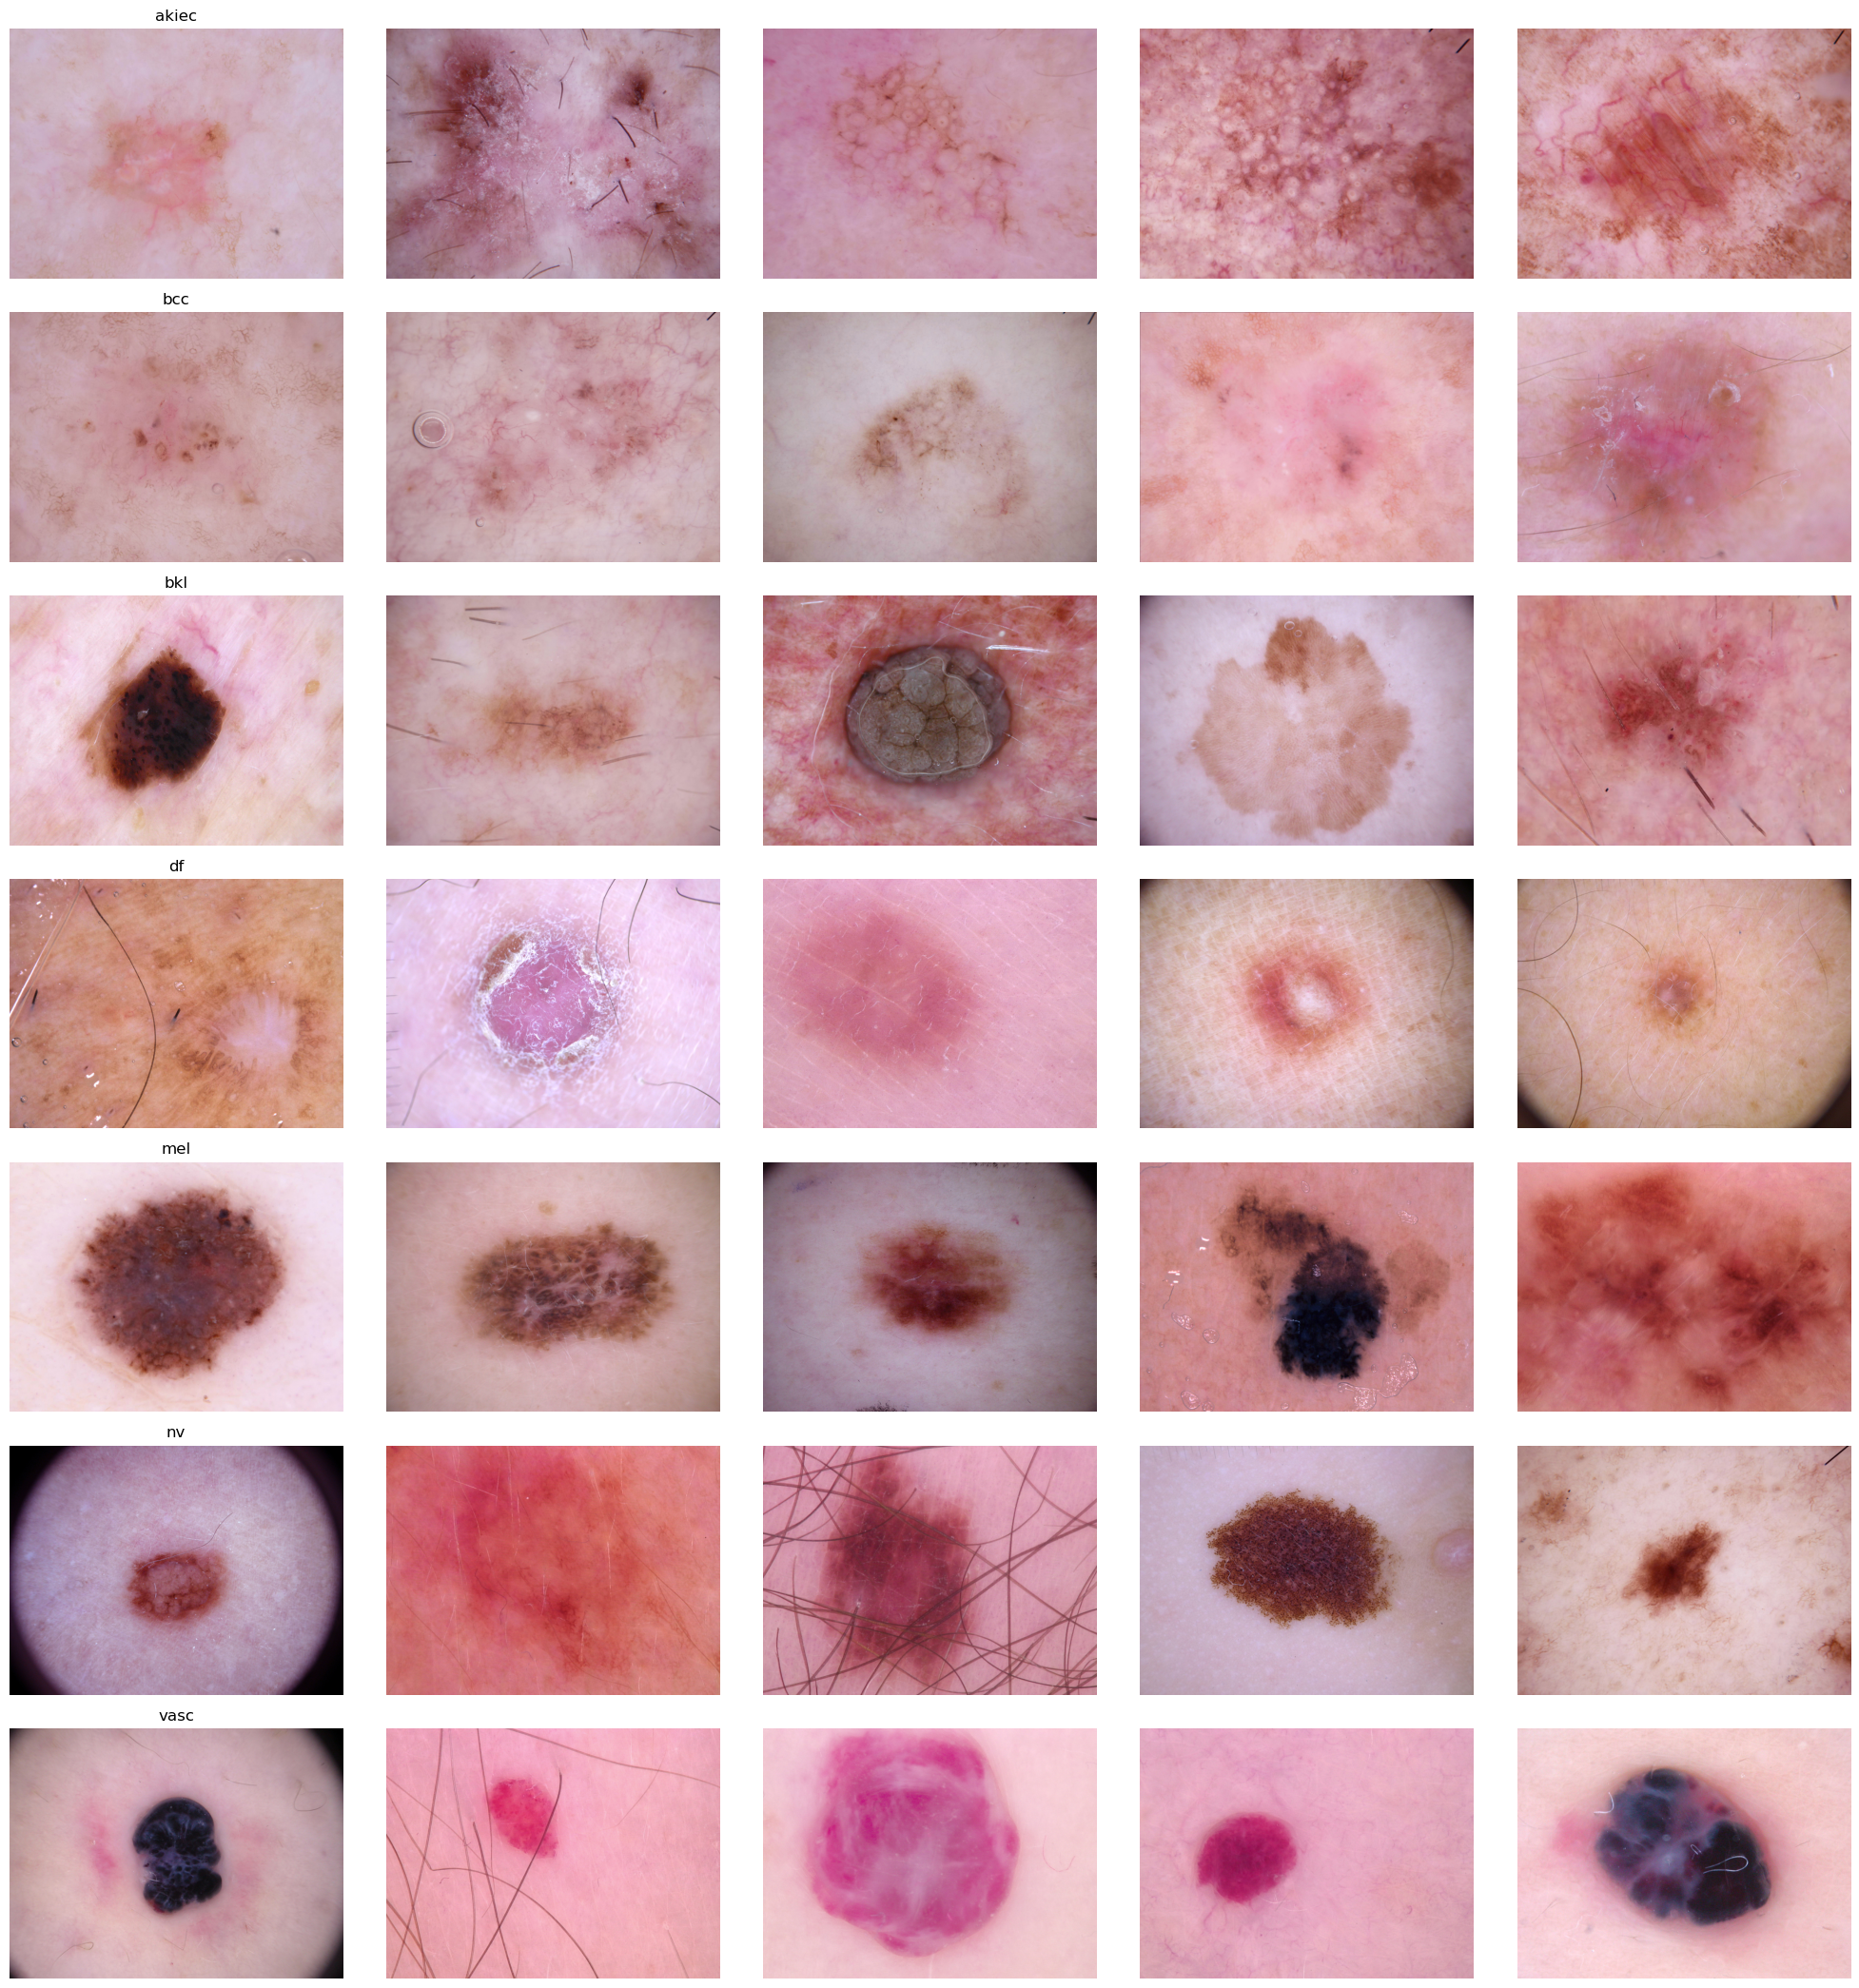

In [7]:
import glob

# Loading image paths
image_path = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob.glob(os.path.join('DATA/', '*', '*.jpg'))
}

# Maping image paths wih loaded dataset
skin_df['path'] = skin_df['image_id'].map(image_path.get)

# Read images in original size
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x)))

# Print label distribution
print(skin_df['dx'].value_counts())

# Define the number of samples per category
n_samples = 5
unique_labels = skin_df['dx'].nunique()

# Create subplots for visualization
fig, m_axs = plt.subplots(unique_labels, n_samples, figsize=(4*n_samples, 3*unique_labels))

# Loop through each label and plot sample images
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name, fontsize=12)  # Set category title
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')  # Hide axis

# Save the figure with high resolution (DPI 500)
plt.tight_layout()
plt.savefig('category_samples.png', dpi=500)
plt.show()

## DATA CLEANING


In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
image            0
dtype: int64

There are 57 missing values in the 'age' feature. To handle this, we will replace the missing values with the mean age of the dataset. 

In [9]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
image           0
dtype: int64

Now there are no missing values.

## DATA VISUALIZATION

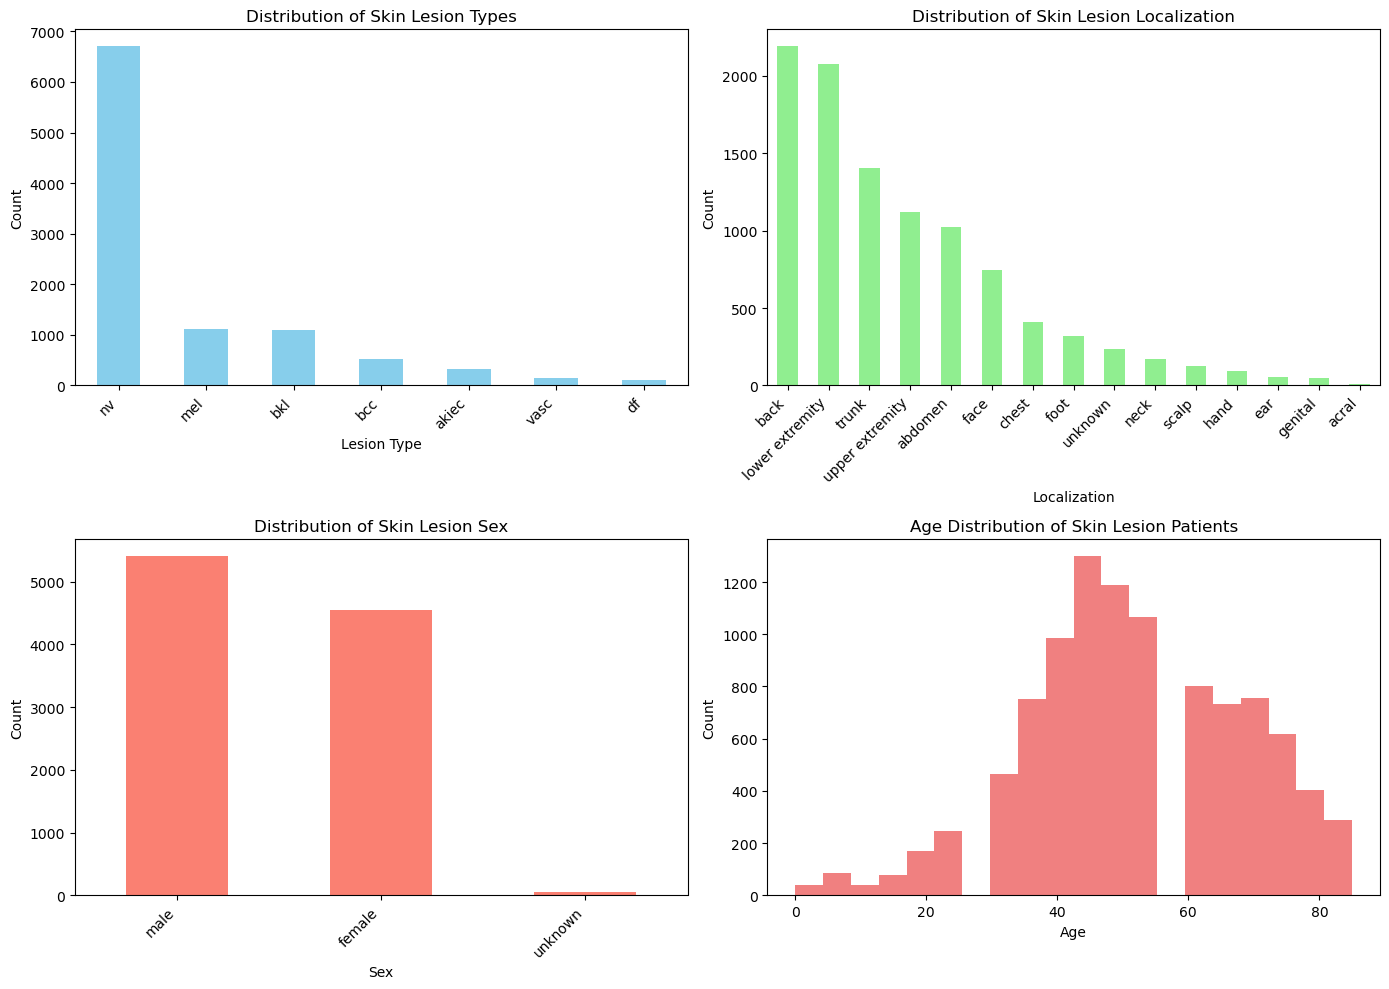

In [11]:
# Distribution of Skin Lesion Types ('dx')
fig, ax1 = plt.subplots(2, 2, figsize=(14, 10))

# Plot for Lesion Types
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1[0, 0], color='skyblue')
ax1[0, 0].set_title('Distribution of Skin Lesion Types')
ax1[0, 0].set_xlabel('Lesion Type')
ax1[0, 0].set_ylabel('Count')
ax1[0, 0].set_xticklabels(ax1[0, 0].get_xticklabels(), rotation=45, ha="right")

# Plot for Localization
skin_df['localization'].value_counts().plot(kind='bar', ax=ax1[0, 1], color='lightgreen')
ax1[0, 1].set_title('Distribution of Skin Lesion Localization')
ax1[0, 1].set_xlabel('Localization')
ax1[0, 1].set_ylabel('Count')
ax1[0, 1].set_xticklabels(ax1[0, 1].get_xticklabels(), rotation=45, ha="right")

# Plot for Sex
skin_df['sex'].value_counts().plot(kind='bar', ax=ax1[1, 0], color='salmon')
ax1[1, 0].set_title('Distribution of Skin Lesion Sex')
ax1[1, 0].set_xlabel('Sex')
ax1[1, 0].set_ylabel('Count')
ax1[1, 0].set_xticklabels(ax1[1, 0].get_xticklabels(), rotation=45, ha="right")

# Here I'm plotting a histogram for age distribution
skin_df['age'].plot(kind='hist', bins=20, ax=ax1[1, 1], color='lightcoral')
ax1[1, 1].set_title('Age Distribution of Skin Lesion Patients')
ax1[1, 1].set_xlabel('Age')
ax1[1, 1].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Data Visualization: Distribution of Key Features

In this section, we explore the distribution of key features in the **HAM10000** dataset. The visualizations help us understand the distribution of various skin lesion types, their localization, sex distribution of the patients, and the age distribution.

#### 1. Distribution of Skin Lesion Types (`'dx'`):
This bar plot shows the distribution of different skin lesion types in the dataset. The lesion types include:
- Basal Cell Carcinoma (BCC)
- Actinic Keratosis (AKIEC)
- Benign Keratosis (BKL)
- Dermatofibroma (DF)
- Melanocytic Nevus (NV)
- Melanomas (MEL)
- Vascular Lesion (VASC)

This visualization allows us to quickly see which lesion types are more prevalent in the dataset.

#### 2. Distribution of Skin Lesion Localization (`'localization'`):
This bar plot illustrates how skin lesions are distributed across different anatomical locations. Understanding localization is essential for correlating lesion characteristics to specific body parts, which can be valuable for classification tasks.

#### 3. Distribution of Sex (`'sex'`):
This bar plot presents the gender distribution of patients in the dataset. It shows the proportion of male and female patients for whom skin lesions are recorded. This can help identify any potential gender-related trends in the occurrence of skin lesions.

#### 4. Age Distribution (`'age'`):
If the age feature is available in the dataset, a histogram is generated to visualize the distribution of patients' ages. This distribution provides insights into the age range most affected by skin lesions and can be important for predictive modeling.

These visualizations help in understanding the underlying structure of the dataset and will guide further analysis and model building.


In [19]:
# this will tell us how many images are associated with each lesion_id
df_ = skin_df.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df_ = df_[df_['image_id'] == 1]

df_.reset_index(inplace=True)

df_.head()

lesion_id  image_id  dx  dx_type  age  sex  localization  path  image  \
0  HAM_0000001         1   1        1    1    1             1     1      1   
1  HAM_0000003         1   1        1    1    1             1     1      1   
2  HAM_0000004         1   1        1    1    1             1     1      1   
3  HAM_0000007         1   1        1    1    1             1     1      1   
4  HAM_0000008         1   1        1    1    1             1     1      1   

   label  
0      1  
1      1  
2      1  
3      1  
4      1

In [43]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df_['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
skin_df['duplicates'] = skin_df['lesion_id']
# apply the function to this new column
skin_df['duplicates'] = skin_df['duplicates'].apply(identify_duplicates)

skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  label  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp      2   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp      2   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp      2   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp      2   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear      2   

       duplicates  
0  has_duplicates  
1  has_duplicates  
2  has_duplicates  
3  has_duplicates  
4  has_duplicates

In [44]:
skin_df['duplicates'].value_counts()

duplicates
no_duplicates     5514
has_duplicates    4501
Name: count, dtype: int64

In [45]:
# now we filter out images that don't have duplicates
df_ = skin_df[skin_df['duplicates'] == 'no_duplicates']

df_.shape

(5514, 9)

## Classication Models- Baseline Moldels

**DENSENET**

In [48]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Assuming your data is already loaded in skin_df
# Here we assume 'image_id' is the name of the column with image filenames
# and that 'dx' is the label column

# Load image paths (adjust this based on where your images are stored)
image_path = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob.glob(os.path.join('DATA/', '*', '*.jpg'))
}

# Map image paths to the DataFrame
skin_df['path'] = skin_df['image_id'].map(image_path.get)

# Resize and load images
def load_and_preprocess_image(img_path, size=(224, 224)):
    img = keras_image.load_img(img_path, target_size=size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image to [0, 1]
    return img_array

# Example: Loading images
X = np.array([load_and_preprocess_image(x) for x in skin_df['path']])
X = np.squeeze(X)  # Remove unnecessary extra dimension

# Encode labels (assuming 'dx' is categorical, use LabelEncoder)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(skin_df['dx'])
y = np.expand_dims(y, axis=1)

# One-hot encode labels for multi-class classification
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=len(le.classes_))

# Define the input size for DenseNet121 (224x224 as expected by the model)
SIZE = 224

# Load DenseNet121 as base model
base_model_densenet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the base model
base_model_densenet121.trainable = False

# Add custom top layers
x = base_model_densenet121.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

# Construct the final model
model_densenet121 = Model(inputs=base_model_densenet121.input, outputs=predictions)

# Compile the model
model_densenet121.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Summary of the model
model_densenet121.summary()

# Data augmentation for training images
datagen_densenet121 = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Split the data into training and test sets (assuming you haven't split yet)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
history_densenet121 = model_densenet121.fit(
    datagen_densenet121.flow(X_train, y_train, batch_size=16),
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate model on test data
score_densenet121 = model_densenet121.evaluate(X_test, y_test)
print('Test accuracy (DenseNet121):', score_densenet121[1])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,094,279 (30.88 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/50


C:\Users\nolastname-a2373\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


501/501 - 268s - 534ms/step - accuracy: 0.6565 - loss: 1.2381 - val_accuracy: 0.6680 - val_loss: 1.9420
Epoch 2/50
501/501 - 171s - 341ms/step - accuracy: 0.6667 - loss: 1.1928 - val_accuracy: 0.6680 - val_loss: 1.9978
Epoch 3/50
501/501 - 164s - 327ms/step - accuracy: 0.6691 - loss: 1.1834 - val_accuracy: 0.6680 - val_loss: 1.9887
Epoch 4/50
501/501 - 165s - 329ms/step - accuracy: 0.6695 - loss: 1.1667 - val_accuracy: 0.6680 - val_loss: 2.0531
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 511ms/step - accuracy: 0.6458 - loss: 2.0763
Test accuracy (DenseNet121): 0.6679980158805847


**RESENET**

In [50]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load ResNet50 as base model
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the base model
base_model_resnet50.trainable = False

# Add custom top layers
x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

# Construct the final model
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

# Compile the model
model_resnet50.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Summary of the model
model_resnet50.summary()

# Data augmentation for training images
datagen_resnet50 = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
history_resnet50 = model_resnet50.fit(
    datagen_resnet50.flow(X_train, y_train, batch_size=16),
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate model on test data
score_resnet50 = model_resnet50.evaluate(X_test, y_test)
print('Test accuracy (ResNet50):', score_resnet50[1])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,693,063 (98.01 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
501/501 - 178s - 355ms/step - accuracy: 0.6072 - loss: 1.3978 - val_accuracy: 0.6680 - val_loss: 1.1451
Epoch 2/50
501/501 - 177s - 353ms/step - accuracy: 0.6483 - loss: 1.2681 - val_accuracy: 0.6680 - val_loss: 1.1829
Epoch 3/50
501/501 - 174s - 348ms/step - accuracy: 0.6654 - loss: 1.2152 - val_accuracy: 0.6680 - val_loss: 1.2460
Epoch 4/50
501/501 - 172s - 343ms/step - accuracy: 0.6690 - loss: 1.1892 - val_accuracy: 0.6680 - val_loss: 1.3287
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 502ms/step - accuracy: 0.6458 - loss: 1.1937
Test accuracy (ResNet50): 0.6679980158805847


**Inception-V3**

In [49]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load InceptionV3 as base model
base_model_inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the base model
base_model_inception_v3.trainable = False

# Add custom top layers
x = base_model_inception_v3.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

# Construct the final model
model_inception_v3 = Model(inputs=base_model_inception_v3.input, outputs=predictions)

# Compile the model
model_inception_v3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Summary of the model
model_inception_v3.summary()

# Data augmentation for training images
datagen_inception_v3 = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
history_inception_v3 = model_inception_v3.fit(
    datagen_inception_v3.flow(X_train, y_train, batch_size=16),
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate model on test data
score_inception_v3 = model_inception_v3.evaluate(X_test, y_test)
print('Test accuracy (InceptionV3):', score_inception_v3[1])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 54, 54,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,908,135 (91.20 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/50
501/501 - 122s - 243ms/step - accuracy: 0.6665 - loss: 1.1716 - val_accuracy: 0.6660 - val_loss: 1.6708
Epoch 2/50
501/501 - 115s - 229ms/step - accuracy: 0.6701 - loss: 1.1355 - val_accuracy: 0.6390 - val_loss: 1.3888
Epoch 3/50
501/501 - 114s - 228ms/step - accuracy: 0.6696 - loss: 1.1249 - val_accuracy: 0.5497 - val_loss: 1.5431
Epoch 4/50
501/501 - 111s - 223ms/step - accuracy: 0.6690 - loss: 1.1126 - val_accuracy: 0.3964 - val_loss: 2.1384
Epoch 5/50
501/501 - 114s - 228ms/step - accuracy: 0.6685 - loss: 1.1059 - val_accuracy: 0.4264 - val_loss: 2.0918
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 294ms/step - accuracy: 0.6235 - loss: 1.4910
Test accuracy (InceptionV3): 0.6390414237976074


**Extended Model**


### BERT

In [52]:
print(skin_df.columns)


Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'label', 'duplicates', 'path'],
      dtype='object')


In [53]:
pip install transformers torch


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/11/c5/2370d96b31eb1841c3a0883a492c15278a6718ccad61bb6a649c80d1d9eb/torch-2.6.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.10.0 from https://files.pythonhosted.org/packages/e0/86/39b65d676ec5732de17b7e3c476e45bb80ec64eb50737a8dce1a4178aba1/typing_extensions-4.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/204.2 MB 3.3 MB/s eta 0:01:02
   ---------------------------------------- 0.6/204.2 MB 8.0 MB/s eta 0:

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [55]:
pip install --upgrade typing-extensions


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [56]:
pip install --upgrade torch


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Read your dataset
skin_df = pd.read_csv('DATA/HAM10000_metadata.csv')

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and pad text data
def tokenize_text(text, max_length=64):
    # Tokenize the text and pad/truncate to the max_length
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length=max_length,
        padding='max_length',     # Pad to max_length
        truncation=True,          # Truncate longer text
        return_attention_mask=True,  # Generate attention masks
        return_tensors='pt',      # Return as PyTorch tensors
    )
    return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0)

# Tokenize the 'dx_type' and 'localization' columns
skin_df['dx_type_input_ids'], skin_df['dx_type_attention_mask'] = zip(*skin_df['dx_type'].apply(tokenize_text))
skin_df['localization_input_ids'], skin_df['localization_attention_mask'] = zip(*skin_df['localization'].apply(tokenize_text))

# Create a custom dataset class to handle BERT inputs
class BERTDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Return the tokenized input for 'dx_type' and 'localization' along with labels
        dx_type_input_ids = torch.tensor(self.df['dx_type_input_ids'].iloc[idx])
        dx_type_attention_mask = torch.tensor(self.df['dx_type_attention_mask'].iloc[idx])
        localization_input_ids = torch.tensor(self.df['localization_input_ids'].iloc[idx])
        localization_attention_mask = torch.tensor(self.df['localization_attention_mask'].iloc[idx])
        
        label = self.df['dx'].iloc[idx]  # Assuming 'dx' is the label column

        return {
            'dx_type_input_ids': dx_type_input_ids,
            'dx_type_attention_mask': dx_type_attention_mask,
            'localization_input_ids': localization_input_ids,
            'localization_attention_mask': localization_attention_mask,
            'label': label
        }

# Create DataLoader for batching
dataset = BERTDataset(skin_df)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Initialize the BERT model for feature extraction
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Example: Process a single batch through BERT
def extract_features(batch):
    dx_type_ids = batch['dx_type_input_ids']
    dx_type_attention = batch['dx_type_attention_mask']
    localization_ids = batch['localization_input_ids']
    localization_attention = batch['localization_attention_mask']
    
    # Get BERT embeddings for dx_type
    dx_type_output = bert_model(dx_type_ids, attention_mask=dx_type_attention)
    dx_type_embeddings = dx_type_output.last_hidden_state.mean(dim=1)  # Get mean embedding for each sentence
    
    # Get BERT embeddings for localization
    localization_output = bert_model(localization_ids, attention_mask=localization_attention)
    localization_embeddings = localization_output.last_hidden_state.mean(dim=1)  # Get mean embedding for each sentence
    
    return dx_type_embeddings, localization_embeddings

# Run through a batch of data and extract features
for batch in dataloader:
    dx_type_embeddings, localization_embeddings = extract_features(batch)
    print(dx_type_embeddings.shape, localization_embeddings.shape)
    break  # Just process one batch for demonstration



C:\Users\nolastname-a2373\AppData\Roaming\Python\Python311\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


C:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nolastname-a2373\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\nolastname-a2373\AppData\Local\Temp\ipykernel_5724\1953812812.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dx_type_input_ids = torch.tensor(self.df['dx_type_input_ids'].iloc[idx])
C:\Users\nolastname-a2373\AppData\Local\Temp\ipykernel_5724\1953812812.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dx_type_attention_mask = torch.tensor(self.df['dx_type_attention_mask'].iloc[idx])
C:\Users\nolastname-a2373\AppData\Local\Temp\ipykernel_5724\1953812812.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  localization_inp

torch.Size([8, 768]) torch.Size([8, 768])


Till this point, the baseline models mentioned in the proposal have been completed, and BERT feature extraction is also done. In the following week, I will use the features obtained from BERT, along with features from images, and I also plan to use logistic regression to understand the effect of adding BERT or textual features.